# Comparing `rust-fc` To Simulation Output

The simulator proccessing code adds realisic noise to the IMU input before sending it to `rust-fc`.

We'll compare the clean "ideal" simulator numbers to what was actually received by `rust-fc`

In [1]:
from psas_packet.io import BinFile
import csv

FPS2M = 0.3048
LBF2N = 4.44822
LBS2KG = 0.453592

# Read data from rust-fc
logfile = BinFile('../logfile-000')
max_acc = 0
rust_time = []
rust_accel_x = []
rust_accel_y = []
rust_accel_z = []
for fourcc, data in logfile.read():
    if fourcc == 'ADIS':
        if data['Acc_X'] > max_acc:
            max_acc = data['Acc_X']
            rust_t = data['timestamp']/1.0e9
        rust_time.append(data['timestamp']/1.0e9)
        rust_accel_x.append(data['Acc_X'])
        rust_accel_y.append(data['Acc_Y'])
        rust_accel_z.append(data['Acc_Z'])

# Read data from JSBSim
max_accel = 0
sim_time = []
sim_accel_x = []
measured_accel_x = []
with open('../simulation/data.csv') as datafile:
    reader = csv.reader(datafile, delimiter=',')
    for row in reader:
        # ignore first line
        if row[0][0] == 'T':
            continue
        sim_time.append(float(row[0]))
        acc = float(row[12])*FPS2M
        if acc > max_accel:
            max_accel = acc
            sim_t = sim_time[-1]
        sim_accel_x.append(acc)
        force_x = float(row[18]) * LBF2N
        weight = float(row[6]) * LBS2KG
        measured_accel_x.append(force_x/weight)

# line up time
sim_offset = rust_t - sim_t
sim_time = [t + sim_offset for t in sim_time]

boundary?


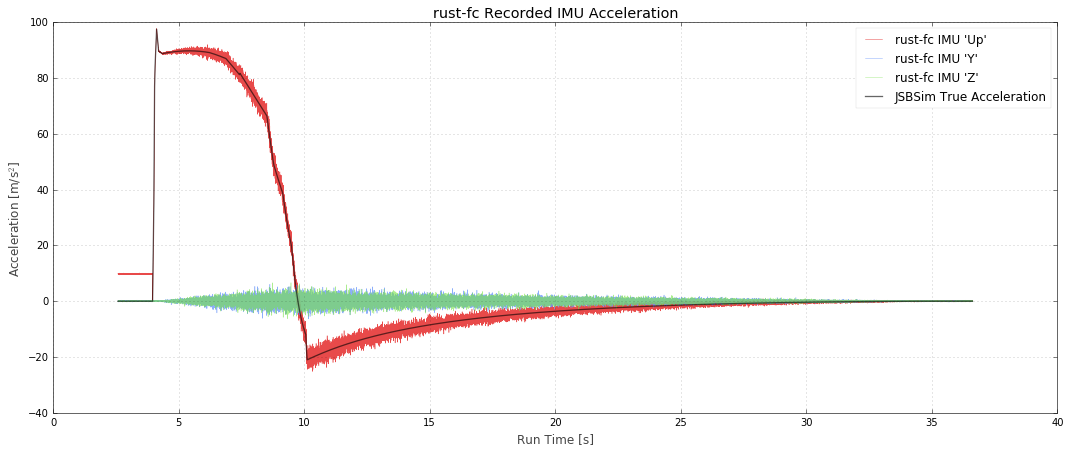

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots(figsize=(18,7))
plt.title(r"rust-fc Recorded IMU Acceleration")
plt.ylabel(r"Acceleration [m/s${}^2$]")
plt.xlabel(r"Run Time [s]")

plt.plot(rust_time, rust_accel_x, alpha=0.8, lw=0.5, label="rust-fc IMU 'Up'")
plt.plot(rust_time, rust_accel_y, alpha=0.8, lw=0.5, label="rust-fc IMU 'Y'")
plt.plot(rust_time, rust_accel_z, alpha=0.6, lw=0.5, label="rust-fc IMU 'Z'")

plt.plot(sim_time, measured_accel_x, 'k-', lw=1.3, alpha=0.6, label="JSBSim True Acceleration")

#plt.ylim()
#plt.xlim()
ax1.legend(loc=1)
plt.show()